In [1]:
import pandas as pd
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from Preprocess import preprocessor, target_transform, CorrelationFilter, categorical_features, role_feature, numerical_features
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import TransformedTargetRegressor

In [5]:
df = pd.read_csv("data_input.csv")
df_filtered = df[df["win_prob"] <= 1].copy()
df_filtered = df_filtered[df_filtered["win_prob"].notna()]
df_filtered = df_filtered.drop("intelligence", axis=1)
df = df_filtered

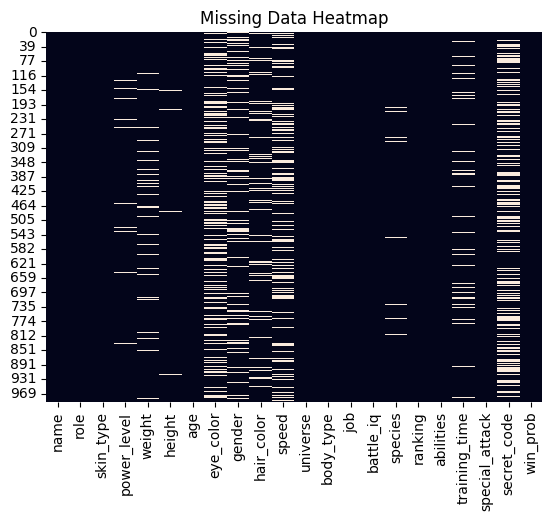

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

In [7]:
df.isnull().sum().sort_values(ascending=False)

secret_code       367
eye_color         313
speed             261
gender            163
hair_color         91
training_time      86
weight             63
power_level        53
species            23
height             12
name                0
special_attack      0
abilities           0
ranking             0
universe            0
battle_iq           0
job                 0
body_type           0
role                0
age                 0
skin_type           0
win_prob            0
dtype: int64

In [8]:
df['power_level'] = df['power_level'].isnull().astype(int)

# Correlate missingness with other features
correlations = df.corr(numeric_only=True)['power_level'].drop('power_level')
print(correlations)

weight          -0.042019
height          -0.051459
age              0.033901
gender           0.028143
speed           -0.023990
battle_iq       -0.017802
ranking         -0.037011
training_time   -0.024419
secret_code     -0.098974
win_prob        -0.163258
Name: power_level, dtype: float64


In [9]:
missing_features = ["secret_code", "eye_color", "speed", "gender", "hair_color", "training_time", "weight", "power_level", "species", "height"]

def top_missingness_correlations(df, top_n=3):
    missing_features = df.columns[df.isnull().any()]

    for feature in missing_features:
        missing_flag = df[feature].isnull().astype(int)
        correlations = df.drop(columns=feature).corrwith(missing_flag, numeric_only=True)
        top_correlated = correlations.abs().sort_values(ascending=False).head(top_n)

        print(f"\n🔍 Missingness Correlations for '{feature}':")
        for idx, value in top_correlated.items():
            print(f"  - {idx}: {value:.3f}")
            

top_missingness_correlations(df, top_n=5)


🔍 Missingness Correlations for 'weight':
  - age: 0.426
  - speed: 0.230
  - win_prob: 0.105
  - power_level: 0.047
  - gender: 0.036

🔍 Missingness Correlations for 'height':
  - battle_iq: 0.066
  - training_time: 0.057
  - power_level: 0.055
  - ranking: 0.037
  - weight: 0.029

🔍 Missingness Correlations for 'eye_color':
  - secret_code: 0.073
  - battle_iq: 0.041
  - training_time: 0.040
  - win_prob: 0.035
  - power_level: 0.020

🔍 Missingness Correlations for 'gender':
  - speed: 0.037
  - battle_iq: 0.026
  - age: 0.022
  - secret_code: 0.017
  - ranking: 0.017

🔍 Missingness Correlations for 'hair_color':
  - battle_iq: 0.240
  - weight: 0.117
  - height: 0.100
  - win_prob: 0.082
  - secret_code: 0.027

🔍 Missingness Correlations for 'speed':
  - win_prob: 0.050
  - training_time: 0.047
  - battle_iq: 0.045
  - ranking: 0.045
  - gender: 0.044

🔍 Missingness Correlations for 'species':
  - ranking: 0.077
  - secret_code: 0.058
  - height: 0.047
  - power_level: 0.022
  - bat

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Detect which features have missing values
features_with_nan = df.columns[df.isnull().any()].tolist()
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

In [18]:
print("\n🔍 Correlations with missingness:")
for feature in features_with_nan:
    df[f'missing_{feature}'] = df[feature].isnull().astype(int)
    correlations = df.corr(numeric_only=True)[f'missing_{feature}'].drop(f'missing_{feature}')
    top_corrs = correlations.abs().sort_values(ascending=False).head(5)
    print(f"\nTop correlations with missingness in '{feature}':")
    print(top_corrs)


🔍 Correlations with missingness:

Top correlations with missingness in 'weight':
age            0.425502
speed          0.229894
win_prob       0.105402
secret_code    0.062175
power_level    0.047204
Name: missing_weight, dtype: float64

Top correlations with missingness in 'height':
secret_code      0.085892
battle_iq        0.066081
training_time    0.057143
power_level      0.055219
ranking          0.037049
Name: missing_height, dtype: float64

Top correlations with missingness in 'eye_color':
missing_weight    0.074114
secret_code       0.041695
battle_iq         0.040519
training_time     0.039998
win_prob          0.035007
Name: missing_eye_color, dtype: float64

Top correlations with missingness in 'gender':
missing_weight    0.039873
speed             0.036861
battle_iq         0.025862
missing_height    0.024631
age               0.021869
Name: missing_gender, dtype: float64

Top correlations with missingness in 'hair_color':
battle_iq         0.240015
weight            0.1

In [19]:
print("\n📊 t-tests for missingness association with numerical features:")

for target in features_with_nan:
    df[f'missing_{target}'] = df[target].isnull().astype(int)
    print(f"\nFeature: {target}")
    for feature in numerical_features:
        if feature != target and df[feature].notnull().sum() > 0:
            try:
                group1 = df[df[f'missing_{target}'] == 1][feature]
                group0 = df[df[f'missing_{target}'] == 0][feature]
                stat, p = ttest_ind(group1, group0, nan_policy='omit')
                if p < 0.05:
                    print(f" - {feature} (p={p:.4f}) → likely MAR")
            except Exception as e:
                print(f" - {feature}: error ({e})")


📊 t-tests for missingness association with numerical features:

Feature: weight
 - age (p=0.0000) → likely MAR
 - speed (p=0.0000) → likely MAR
 - win_prob (p=0.0010) → likely MAR

Feature: height
 - battle_iq (p=0.0394) → likely MAR
 - secret_code (p=0.0074) → likely MAR

Feature: eye_color

Feature: gender

Feature: hair_color
 - weight (p=0.0004) → likely MAR
 - height (p=0.0019) → likely MAR
 - battle_iq (p=0.0000) → likely MAR
 - win_prob (p=0.0106) → likely MAR

Feature: speed

Feature: species
 - ranking (p=0.0167) → likely MAR

Feature: training_time


In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Detect features with missing values
features_with_nan = df.columns[df.isnull().any()].tolist()

# Print header
print("\n🤖 Logistic Regression to Predict Missingness (Higher AUC → More Likely MAR):")

for target in features_with_nan:
    # Create binary mask for missingness
    df[f'missing_{target}'] = df[target].isnull().astype(int)
    y = df[f'missing_{target}']
    X = df.drop(columns=[target, f'missing_{target}'])

    # Skip if almost all missing or almost none missing
    if y.sum() < 5 or y.sum() > len(y) - 5:
        print(f" - {target}: Skipped (too few or too many missing)")
        continue

    # Drop constant features
    X = X.loc[:, X.nunique(dropna=False) > 1]

    # Redetect numerical/categorical
    num_features = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

    # Define preprocessing
    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ])

    # Build pipeline
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    # Score using ROC AUC
    try:
        auc = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc').mean()
        print(f" - {target}: AUC = {auc:.3f}")
    except Exception as e:
        print(f" - {target}: Error: {e}")



🤖 Logistic Regression to Predict Missingness (Higher AUC → More Likely MAR):
 - weight: AUC = 0.963
 - height: AUC = 0.430
 - eye_color: AUC = 0.472
 - gender: AUC = 0.481
 - hair_color: AUC = 0.721
 - speed: AUC = 0.470
 - species: AUC = 0.683
 - training_time: AUC = 0.486


Outputs if >0.5 likely MAR and using correlation matrix shows which are likely the cause
Impute accordingly

MAR = weight, hair_colour, "species" (possibly weak)
NMAR = height possible,  but modelable using weight and species
MCAR = others (use random sampling)
